In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout, LSTM, Embedding, concatenate, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils.class_weight import compute_sample_weight

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from processing import get_class_weights, get_prior, merge4Vectors, read_data, prepare_input
from processing import multiclass_encode_labels, apply_standard_scaler, apply_cat_encoder, binary_encode_labels

In [2]:
"""
Stops model training if validation loss does not improve over five subsequent epochs.
Documentation: # https://keras.io/api/callbacks/early_stopping/
"""

EarlyStopCallback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    mode="min",
    verbose=1
)

In [3]:
def simple_net(N_features, N_cat_features, print_model=True, learning_rate=1e-4):
    optimizer = Adam(lr=learning_rate)
    initializer = tf.keras.initializers.HeNormal(seed=0)

    input = Input(shape=(N_features,))
    input_cat = Input(shape=(N_cat_features,))

    unique_cat = 8
    embedding_size = 100
    embedding_cat = Embedding(unique_cat, embedding_size)(input_cat)

    x_c = Dense(128, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(input_cat)
    x_c = Dropout(0.125)(x_c)
    x = Dense(128, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(input) 
    x = Dropout(0.125)(x)

    merged = concatenate([x_c, x])
    x = Dense(128, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(merged)
    x = Dropout(0.125)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input, input_cat], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if print_model:
        print(model.summary())

    return model


def binary_LSTM(N_features, N_cat_features=0, print_model=True, learning_rate=1e-5):
    
    optimizer = Adam(lr=learning_rate)
    initializer = tf.keras.initializers.HeNormal(seed=0)
    
    input = Input(shape=(N_features, 4), name='4-vector')
    input_cat = Input(shape=(N_cat_features,), name='OBJ')
    input_MET = Input(shape=(2,), name='MET')
    unique_cat = 8
    embedding_size = 100
    embedding_cat = Embedding(unique_cat, embedding_size, name='OBJ_Embedding')(input_cat)

    x = concatenate([embedding_cat, input])
    x = Bidirectional(LSTM(100, activation='relu', return_sequences=True, 
                           kernel_initializer=initializer, recurrent_dropout=0.125))(x)
    x = Bidirectional(LSTM(100, activation='relu', kernel_initializer=initializer,  recurrent_dropout=0.125))(x)

    x_MET = Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(input_MET) 
    merged = concatenate([x_MET, x])
    x = Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(merged) 
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input, input_cat, input_MET], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if print_model:
        print(model.summary())

    return model

def multiclass_LSTM(N_features, N_cat_features=0, print_model=True, learning_rate=1e-5):
    
    optimizer = Adam(lr=learning_rate)
    initializer = tf.keras.initializers.HeNormal(seed=0)

    input = Input(shape=(N_features, 4))
    input_cat = Input(shape=(N_cat_features,))
    input_MET = Input(shape=(2,))
    unique_cat = 8
    embedding_size = 100
    
    embedding_cat = Embedding(unique_cat, embedding_size)(input_cat)

    x = concatenate([embedding_cat, input])

    x = Bidirectional(LSTM(100, activation='relu', return_sequences=True, 
                           recurrent_dropout=0.125, kernel_initializer=initializer))(x)
    x = Bidirectional(LSTM(100, activation='relu', recurrent_dropout=0.125, kernel_initializer=initializer))(x)

    x_MET = Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(input_MET) 
    merged = concatenate([x_MET, x])
    x = Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(merged)
    output = Dense(5, activation='softmax')(x)

    model = Model(inputs=[input, input_cat, input_MET], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(), 'Precision', 'Recall'])

    if print_model:
        print(model.summary())

    return model

def multiclass_multioutput_LSTM(N_features, N_cat_features=0, print_model=True, learning_rate=1e-5):
    optimizer = Adam(lr=learning_rate)
    initializer = tf.keras.initializers.HeNormal(seed=0)

    input = Input(shape=(N_features, 4))
    input_cat = Input(shape=(N_cat_features,))
    input_MET = Input(shape=(2,))
    unique_cat = 8
    embedding_size = 100
    embedding_cat = Embedding(unique_cat, embedding_size)(input_cat)

    x = concatenate([embedding_cat, input])

    x = Bidirectional(LSTM(100, activation='relu', return_sequences=True, recurrent_dropout=0.125, kernel_initializer=initializer))(x)
    x = Bidirectional(LSTM(100, activation='relu', recurrent_dropout=0.125, kernel_initializer=initializer))(x)

    x_MET = Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(input_MET) 
    merged = concatenate([x_MET, x])
    x = Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(merged)
    multiclass_output = Dense(5, activation='softmax')(x)
    merged = concatenate([x, multiclass_output])
    x = Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2')(x)
    binary_output = Dense(1, activation='sigmoid')(x)


    model = Model(inputs=[input, input_cat, input_MET], outputs=[binary_output, multiclass_output])
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=optimizer)

    if print_model:
        print(model.summary())

    return model

# Training procedure for the simple Neural Network

In [9]:
df = read_data()
TARGET = ['process ID']
df, cat_df = prepare_input(df, particle_count=False)
FEATURES = df.drop(['event weight', 'event ID', 'process ID'], axis=1).columns.to_list() 

X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_cat, X_test_cat, y_train, y_test = train_test_split(cat_df[[f'obj{x}' for x in range(1,11,1)]], cat_df[TARGET], test_size=0.1, 
                                                         shuffle=True, random_state=42, stratify=cat_df[TARGET])

X_train = np.array([np.vstack(col) for col in X_train.values]) 
X_test = np.array([np.vstack(col) for col in X_test.values])
X_train_cat = X_train_cat.to_numpy()
X_test_cat = X_test_cat.to_numpy()
y_train_enc = np.array(binary_encode_labels(y_train['process ID'])).astype(np.float32)
y_test_enc = np.array(binary_encode_labels(y_test['process ID'])).astype(np.float32)

simple_model = simple_net(len(X_train[0]), len(X_train_cat[0]), learning_rate=1e-4, print_model=False)
history = simple_model.fit([X_train, X_train_cat], y_train_enc, batch_size=512, epochs=50, 
                                validation_split=0.05, verbose=1,  callbacks=[EarlyStopCallback])

print(simple_model.evaluate([X_test, X_test_cat], y_test_enc))
# tf.keras.models.save_model(simple_model, 'simple_NN.h5')

Epoch 1/50
334/334 [==============================] - 3s 6ms/step - loss: 8.1169 - accuracy: 0.6994 - val_loss: 6.5458 - val_accuracy: 0.8416
Epoch 2/50
334/334 [==============================] - 2s 6ms/step - loss: 6.2761 - accuracy: 0.8076 - val_loss: 5.2593 - val_accuracy: 0.8498
Epoch 3/50
334/334 [==============================] - 2s 5ms/step - loss: 5.0384 - accuracy: 0.8264 - val_loss: 4.2868 - val_accuracy: 0.8518
Epoch 4/50
334/334 [==============================] - 2s 5ms/step - loss: 4.1152 - accuracy: 0.8370 - val_loss: 3.5407 - val_accuracy: 0.8531
Epoch 5/50
334/334 [==============================] - 2s 7ms/step - loss: 3.4087 - accuracy: 0.8389 - val_loss: 2.9601 - val_accuracy: 0.8540
Epoch 6/50
334/334 [==============================] - 4s 12ms/step - loss: 2.8575 - accuracy: 0.8431 - val_loss: 2.5015 - val_accuracy: 0.8560
Epoch 7/50
334/334 [==============================] - 2s 7ms/step - loss: 2.4260 - accuracy: 0.8438 - val_loss: 2.1346 - val_accuracy: 0.8549
Epoch

# Training procedure for the simple Neural Network + Particle Count

In [10]:
df = read_data()
TARGET = ['process ID']
df, cat_df = prepare_input(df, particle_count=True)
FEATURES = df.drop(['event weight', 'event ID', 'process ID'], axis=1).columns.to_list() 

X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_cat, X_test_cat, y_train, y_test = train_test_split(cat_df[[f'obj{x}' for x in range(1,11,1)]], cat_df[TARGET], test_size=0.1, 
                                                         shuffle=True, random_state=42, stratify=cat_df[TARGET])

X_train = np.array([np.vstack(col) for col in X_train.values]) 
X_test = np.array([np.vstack(col) for col in X_test.values])
X_train_cat = X_train_cat.to_numpy()
X_test_cat = X_test_cat.to_numpy()
y_train_enc = np.array(binary_encode_labels(y_train['process ID'])).astype(np.float32)
y_test_enc = np.array(binary_encode_labels(y_test['process ID'])).astype(np.float32)

simple_model = simple_net(len(X_train[0]), len(X_train_cat[0]), learning_rate=1e-4, print_model=False)
history = simple_model.fit([X_train, X_train_cat], y_train_enc, batch_size=512, epochs=50, 
                                validation_split=0.05, verbose=1,  callbacks=[EarlyStopCallback])

print(simple_model.evaluate([X_test, X_test_cat], y_test_enc))
# tf.keras.models.save_model(simple_model, 'simple_NN+particlecount.h5')

Epoch 1/50
334/334 [==============================] - 3s 6ms/step - loss: 8.6165 - accuracy: 0.6249 - val_loss: 6.7733 - val_accuracy: 0.8380
Epoch 2/50
334/334 [==============================] - 2s 5ms/step - loss: 6.5767 - accuracy: 0.7918 - val_loss: 5.5642 - val_accuracy: 0.8502
Epoch 3/50
334/334 [==============================] - 2s 6ms/step - loss: 5.3853 - accuracy: 0.8150 - val_loss: 4.6237 - val_accuracy: 0.8528
Epoch 4/50
334/334 [==============================] - 2s 6ms/step - loss: 4.4752 - accuracy: 0.8283 - val_loss: 3.8789 - val_accuracy: 0.8534
Epoch 5/50
334/334 [==============================] - 2s 7ms/step - loss: 3.7549 - accuracy: 0.8371 - val_loss: 3.2777 - val_accuracy: 0.8564
Epoch 6/50
334/334 [==============================] - 3s 8ms/step - loss: 3.1781 - accuracy: 0.8424 - val_loss: 2.7903 - val_accuracy: 0.8571
Epoch 7/50
334/334 [==============================] - 2s 6ms/step - loss: 2.7070 - accuracy: 0.8457 - val_loss: 2.3896 - val_accuracy: 0.8561
Epoch 

# Training procedure for the binary LSTM model

In [5]:
df = read_data()
TARGET = ['process ID']
df, cat_df = prepare_input(df, particle_count=False)
df = merge4Vectors(df)
FEATURES = [f'4Vector{x}' for x in range(1,11,1)]
MET_FEATURES = ['MET', 'METphi']

X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_MET, X_test_MET, y_train, y_test = train_test_split(df[MET_FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_cat, X_test_cat, y_train, y_test = train_test_split(cat_df[[f'obj{x}' for x in range(1,11,1)]], cat_df[TARGET], test_size=0.1, 
                                                         shuffle=True, random_state=42, stratify=cat_df[TARGET])

X_train = np.array([np.vstack(col) for col in X_train.values]) 
X_test = np.array([np.vstack(col) for col in X_test.values])
X_train_cat = X_train_cat.to_numpy()
X_test_cat = X_test_cat.to_numpy()
X_train_MET = X_train_MET.to_numpy()
X_test_MET = X_test_MET.to_numpy()
y_train_enc = np.array(binary_encode_labels(y_train['process ID'])).astype(np.float32)
y_test_enc = np.array(binary_encode_labels(y_test['process ID'])).astype(np.float32)

recurrent_model = binary_LSTM(len(X_train[0]), len(X_train_cat[0]), False, learning_rate=1e-4)
history = recurrent_model.fit([X_train, X_train_cat, X_train_MET], y_train_enc,  batch_size=512, epochs=25,  
                              validation_split=0.05, verbose=1, callbacks=[EarlyStopCallback]) 

print(recurrent_model.evaluate([X_test, X_test_cat, X_test_MET], y_test_enc))
# tf.keras.models.save_model(recurrent_model, 'LSTM_binary.h5')

Epoch 1/25
334/334 [==============================] - 147s 415ms/step - loss: 2.7401 - accuracy: 0.7677 - val_loss: 2.1397 - val_accuracy: 0.8629
Epoch 2/25
334/334 [==============================] - 135s 404ms/step - loss: 2.0343 - accuracy: 0.8631 - val_loss: 1.7582 - val_accuracy: 0.8660
Epoch 3/25
334/334 [==============================] - 142s 427ms/step - loss: 1.6918 - accuracy: 0.8670 - val_loss: 1.5179 - val_accuracy: 0.8644
Epoch 4/25
334/334 [==============================] - 139s 417ms/step - loss: 1.4746 - accuracy: 0.8666 - val_loss: 1.3559 - val_accuracy: 0.8683
Epoch 5/25
334/334 [==============================] - 121s 362ms/step - loss: 1.3264 - accuracy: 0.8682 - val_loss: 1.2433 - val_accuracy: 0.8692
Epoch 6/25
334/334 [==============================] - 122s 366ms/step - loss: 1.2231 - accuracy: 0.8670 - val_loss: 1.1609 - val_accuracy: 0.8671
Epoch 7/25
334/334 [==============================] - 120s 358ms/step - loss: 1.1446 - accuracy: 0.8676 - val_loss: 1.0948 -

# Training procedure for the multi-output model

In [7]:
df = read_data()
TARGET = ['process ID']
FEATURES = df.drop(['event weight', 'event ID', 'process ID'], axis=1).columns.to_list() 
LABELS =['4top', 'ttbar', 'ttbarHiggs', 'ttbarW', 'ttbarZ']

df[[f'E{x}' for x in range(1,11,1)]] = np.log(df[[f'E{x}' for x in range(1,11,1)]].astype(float))
df[[f'pt{x}' for x in range(1,11,1)]] = np.log(df[[f'pt{x}' for x in range(1,11,1)]].astype(float))
df['MET'] = np.log(df['MET'].astype(float))
df = apply_cat_encoder(df)
df= apply_standard_scaler(df)
df = df.fillna(0, axis=1) # fill up nan values in the four vectors op te particles. Safe to use on the whole dataframe as the other columns do not have nan values. 
df = merge4Vectors(df)

cat_df = df[[f'obj{x}' for x in range(1,11,1)]+['process ID']]
df.drop([f'obj{x}' for x in range(1,11,1)], axis=1, inplace=True)
FEATURES = [f'4Vector{x}' for x in range(1,11,1)]

MET_FEATURES = ['MET', 'METphi']

X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_MET, X_test_MET, y_train, y_test = train_test_split(df[MET_FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_cat, X_test_cat, y_train, y_test = train_test_split(cat_df[[f'obj{x}' for x in range(1,11,1)]], cat_df[TARGET], test_size=0.1, 
                                                         shuffle=True, random_state=42, stratify=cat_df[TARGET])

X_train = np.array([np.vstack(col) for col in X_train.values]).reshape(-1,10,4,1)  # X_train.to_numpy() # 
X_test =  np.array([np.vstack(col) for col in X_test.values]).reshape(-1,10,4,1) #X_test.to_numpy() #
X_train_cat = X_train_cat.to_numpy()
X_test_cat = X_test_cat.to_numpy()
X_train_MET = X_train_MET.to_numpy()
X_test_MET = X_test_MET.to_numpy()
y_train_enc = np.array(multiclass_encode_labels(y_train['process ID'])).astype(np.float32)
y_test_enc = np.array(multiclass_encode_labels(y_test['process ID'])).astype(np.float32)
y_train_enc_bin = np.array(binary_encode_labels(y_train['process ID'])).astype(np.float32)
y_test_enc_bin = np.array(binary_encode_labels(y_test['process ID'])).astype(np.float32)

model = multiclass_multioutput_LSTM(len(X_train[0]), len(X_train_cat[0]), print_model=False, learning_rate=1e-4)
history = model.fit([X_train, X_train_cat, X_train_MET], [y_train_enc_bin, y_train_enc], batch_size=512, epochs=25, validation_split=0.05, 
                              verbose=1, callbacks=[EarlyStopCallback])

# tf.keras.models.save_model(recurrent_model, 'LSTM_multioutput.h5')
predictions = model.predict([X_test, X_test_cat, X_test_MET])
preds = np.array(predictions[0].flatten()  > 0.5, dtype=np.float32)
print('The accuracy score is:', K.mean(K.equal(y_test_enc_bin, preds)))

Epoch 1/25
334/334 [==============================] - 169s 483ms/step - loss: 5.2798 - dense_10_loss: 0.5288 - dense_8_loss: 1.2436 - val_loss: 4.2088 - val_dense_10_loss: 0.3268 - val_dense_8_loss: 0.9677
Epoch 2/25
334/334 [==============================] - 162s 485ms/step - loss: 4.0467 - dense_10_loss: 0.3275 - dense_8_loss: 0.9621 - val_loss: 3.6117 - val_dense_10_loss: 0.3187 - val_dense_8_loss: 0.9531
Epoch 3/25
334/334 [==============================] - 165s 495ms/step - loss: 3.4954 - dense_10_loss: 0.3192 - dense_8_loss: 0.9491 - val_loss: 3.1895 - val_dense_10_loss: 0.3159 - val_dense_8_loss: 0.9485
Epoch 4/25
334/334 [==============================] - 161s 482ms/step - loss: 3.0975 - dense_10_loss: 0.3143 - dense_8_loss: 0.9413 - val_loss: 2.8734 - val_dense_10_loss: 0.3151 - val_dense_8_loss: 0.9416
Epoch 5/25
334/334 [==============================] - 164s 490ms/step - loss: 2.8002 - dense_10_loss: 0.3139 - dense_8_loss: 0.9326 - val_loss: 2.6359 - val_dense_10_loss: 0.31

# Training procedure for the multiclass LSTM model

In [9]:
df = read_data()
TARGET = ['process ID']
FEATURES = df.drop(['event weight', 'event ID', 'process ID'], axis=1).columns.to_list() 
LABELS =['4top', 'ttbar', 'ttbarHiggs', 'ttbarW', 'ttbarZ']
PRIOR = get_prior(df['process ID'])
class_weights = get_class_weights(df['process ID'])


df[[f'E{x}' for x in range(1,11,1)]] = np.log(df[[f'E{x}' for x in range(1,11,1)]].astype(float))
df[[f'pt{x}' for x in range(1,11,1)]] = np.log(df[[f'pt{x}' for x in range(1,11,1)]].astype(float))
df['MET'] = np.log(df['MET'].astype(float))
df = apply_cat_encoder(df)
df = apply_standard_scaler(df)
df = df.fillna(0, axis=1) # fill up nan values in the four vectors op te particles. Safe to use on the whole dataframe as the other columns do not have nan values. 
df = merge4Vectors(df)

cat_df = df[[f'obj{x}' for x in range(1,11,1)]+['process ID']]
df.drop([f'obj{x}' for x in range(1,11,1)], axis=1, inplace=True)
FEATURES = [f'4Vector{x}' for x in range(1,11,1)]
MET_FEATURES = ['MET', 'METphi']

X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_MET, X_test_MET, y_train, y_test = train_test_split(df[MET_FEATURES], df[TARGET], test_size=0.1, shuffle=True, random_state=42, stratify=df[TARGET])
X_train_cat, X_test_cat, y_train, y_test = train_test_split(cat_df[[f'obj{x}' for x in range(1,11,1)]], cat_df[TARGET], test_size=0.1, 
                                                         shuffle=True, random_state=42, stratify=cat_df[TARGET])

X_train = np.array([np.vstack(col) for col in X_train.values]).reshape(-1,10,4,1) 
X_test =  np.array([np.vstack(col) for col in X_test.values]).reshape(-1,10,4,1) 
X_train_cat = X_train_cat.to_numpy()
X_test_cat = X_test_cat.to_numpy()
X_train_MET = X_train_MET.to_numpy()
X_test_MET = X_test_MET.to_numpy()
y_train_enc = np.array(multiclass_encode_labels(y_train['process ID'])).astype(np.float32)
y_test_enc = np.array(multiclass_encode_labels(y_test['process ID'])).astype(np.float32)
y_train_enc_bin = np.array(binary_encode_labels(y_train['process ID'])).astype(np.float32)
y_test_enc_bin = np.array(binary_encode_labels(y_test['process ID'])).astype(np.float32)

recurrent_model = multiclass_LSTM(len(X_train[0]), len(X_train_cat[0]), print_model=False, learning_rate=1e-4)
history = recurrent_model.fit([X_train, X_train_cat, X_train_MET], y_train_enc, batch_size=512, epochs=25, validation_split=0.05, 
                              verbose=1, class_weight=class_weights, callbacks=[EarlyStopCallback])
# tf.keras.models.save_model(recurrent_model, 'LSTM_multiclass.h5')

Epoch 1/25
334/334 [==============================] - 214s 614ms/step - loss: 6.0089 - categorical_accuracy: 0.4716 - precision: 0.7685 - recall: 0.1637 - val_loss: 3.0611 - val_categorical_accuracy: 0.5784 - val_precision: 0.8868 - val_recall: 0.3569
Epoch 2/25
334/334 [==============================] - 203s 608ms/step - loss: 5.0832 - categorical_accuracy: 0.5844 - precision: 0.8826 - recall: 0.3662 - val_loss: 2.7946 - val_categorical_accuracy: 0.5796 - val_precision: 0.8504 - val_recall: 0.3770
Epoch 3/25
334/334 [==============================] - 200s 599ms/step - loss: 4.7800 - categorical_accuracy: 0.5929 - precision: 0.8696 - recall: 0.3848 - val_loss: 2.5571 - val_categorical_accuracy: 0.5968 - val_precision: 0.8744 - val_recall: 0.3867
Epoch 4/25
334/334 [==============================] - 204s 609ms/step - loss: 4.5815 - categorical_accuracy: 0.5992 - precision: 0.8645 - recall: 0.3897 - val_loss: 2.3868 - val_categorical_accuracy: 0.5999 - val_precision: 0.8595 - val_recall:

# Evaluation for multiclass LSTM

In [10]:
predictions = recurrent_model.predict([X_test, X_test_cat, X_test_MET])
predictions = (predictions == predictions.max(axis=1)[:,None]).astype(int)
print(metrics.classification_report(y_test_enc, predictions, target_names=LABELS))

              precision    recall  f1-score   support

        4top       0.88      0.84      0.86     10000
       ttbar       0.49      0.58      0.53      2500
  ttbarHiggs       0.29      0.35      0.32      2500
      ttbarW       0.34      0.44      0.39      2500
      ttbarZ       0.30      0.16      0.21      2500

   micro avg       0.61      0.61      0.61     20000
   macro avg       0.46      0.47      0.46     20000
weighted avg       0.62      0.61      0.61     20000
 samples avg       0.61      0.61      0.61     20000



In [11]:
"""
With prior
"""

predictions = recurrent_model.predict([X_test, X_test_cat, X_test_MET])
post = np.array([np.array(vect*PRIOR) for vect in predictions])
post = (post == post.max(axis=1)[:,None]).astype(int)
print(metrics.classification_report(y_test_enc, post, target_names=LABELS))

              precision    recall  f1-score   support

        4top       0.79      0.95      0.86     10000
       ttbar       0.49      0.57      0.53      2500
  ttbarHiggs       0.35      0.20      0.25      2500
      ttbarW       0.36      0.42      0.39      2500
      ttbarZ       0.34      0.09      0.14      2500

   micro avg       0.64      0.64      0.64     20000
   macro avg       0.47      0.45      0.43     20000
weighted avg       0.59      0.64      0.59     20000
 samples avg       0.64      0.64      0.64     20000



In [12]:
"""
With inverse prior
"""

predictions = recurrent_model.predict([X_test, X_test_cat, X_test_MET])
post = np.array([np.array(vect*(PRIOR**-1)) for vect in predictions])
post = (post == post.max(axis=1)[:,None]).astype(int)
print(metrics.classification_report(y_test_enc, post, target_names=LABELS))

              precision    recall  f1-score   support

        4top       0.94      0.58      0.72     10000
       ttbar       0.49      0.58      0.53      2500
  ttbarHiggs       0.20      0.48      0.28      2500
      ttbarW       0.34      0.44      0.38      2500
      ttbarZ       0.26      0.18      0.21      2500

   micro avg       0.50      0.50      0.50     20000
   macro avg       0.45      0.45      0.43     20000
weighted avg       0.63      0.50      0.54     20000
 samples avg       0.50      0.50      0.50     20000



# MULTICLASS VISUALISATIONS

In [18]:
# won't run on windows, generate plot on linux or colab
tf.keras.utils.plot_model(recurrent_model, "resnet.png", show_shapes=False, show_layer_names=False, dpi=60)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


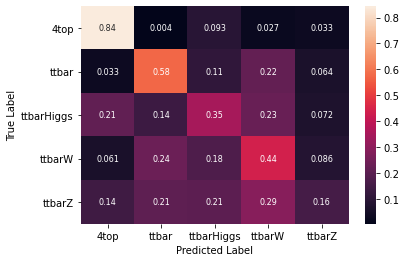

In [14]:
matrix = metrics.confusion_matrix(y_test_enc.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(matrix, index=LABELS, columns=LABELS)
df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 8})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()